In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import seaborn
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import models
from PIL import Image
from facenet_pytorch import MTCNN

In [3]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


In [4]:
gestures=[]

for root, dirs, files in os.walk('kinect_leap_dataset'):
    if any(x in root for x in ['G1','G5','G9']) & ('G10' not in root):
        for name in files:            
            f = os.path.join(root, name)
            if 'rgb' in f :
                gestures.append((f,root[-2:]))

In [5]:
def get_box(file):
    with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5) as hands:
        
        image = cv2.imread(file)
#         print(2)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         print(0)
        

        if results.multi_handedness:
            
#             print(1)

            image_height, image_width, _ = image.shape
#             print(results.multi_hand_landmarks[0])

            x_max=0
            y_max=0
            x_min=image_width
            y_min=image_height
            
#             

            for i in range(len(results.multi_hand_landmarks[0].landmark)):
                
#                 if ()
#                 print(i, len(results.multi_hand_landmarks[0].landmark))
                x_max=max(results.multi_hand_landmarks[0].landmark[i].x,x_max)
                y_max=max(results.multi_hand_landmarks[0].landmark[i].y,y_max)
                x_min=min(results.multi_hand_landmarks[0].landmark[i].x,x_min)
                y_min=min(results.multi_hand_landmarks[0].landmark[i].y,y_min)
                
#                 print(results.multi_hand_landmarks[0].landmark[i])

            x_max=int(x_max*image_width*1.2)
            y_max=int(y_max*image_height*1.2)
            x_min=int(x_min*image_width*0.8)
            y_min=int(y_min*image_height*0.8) 
            x_max=max(x_max,0)
            y_max=max(y_max,0)
            x_min=max(x_min,0)
            y_min=max(y_min,0)
            x_max=min(x_max,image_width)
            y_max=min(y_max,image_height)
            x_min=min(x_min,image_width)
            y_min=min(y_min,image_height)
 

            return (image_width,image_height, x_min,y_min,x_max,y_max)

In [6]:
def get_hand(file):
       with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5) as hands:
        image = cv2.imread(file)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_handedness:

            image_height, image_width, _ = image.shape

     

            return (image_width,image_height, x_min,y_min,x_max,y_max)
    
    

In [7]:
columns=['filename','class','width','height','xmin','ymin','xmax','ymax']
data = pd.DataFrame(columns=columns)

In [8]:
i=0
for file, label in gestures:
    params=get_box(file)
#     print(list(params))
    if params:
        data.loc[i,'filename']=file
        data.loc[i,'class']=label
        data.iloc[i,2:]=list(params)
        i+=1
    

In [9]:
data.head()

,filename,class,width,height,xmin,ymin,xmax,ymax
0,kinect_leap_dataset\acquisitions\P1\G1\10_rgb.png,G1,1280,960,573,211,1004,465
1,kinect_leap_dataset\acquisitions\P1\G1\1_rgb.png,G1,1280,960,576,200,955,416
2,kinect_leap_dataset\acquisitions\P1\G1\3_rgb.png,G1,1280,960,609,214,1046,443
3,kinect_leap_dataset\acquisitions\P1\G1\4_rgb.png,G1,1280,960,559,211,980,415
4,kinect_leap_dataset\acquisitions\P1\G1\5_rgb.png,G1,1280,960,470,188,838,383


G1


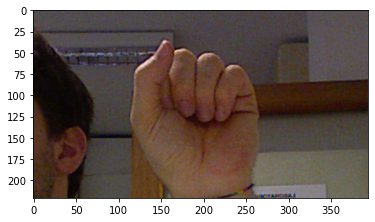

In [10]:
i=5
print(data['class'][i])
plt.imshow(plt.imread(data.filename[i])[data.ymin[i]:data.ymax[i], data.xmin[i]:data.xmax[i]])

In [11]:
class_dict = {'G1': 0,'G5': 1,  'G9': 2}
data['class'] = data['class'].apply(lambda x:  class_dict[x])

In [12]:
# Обучаем на три класса: ладонь, виктори и кулак.

In [13]:
transform = tt.Compose(
                        [                       
                         # Настройки для расширения датасета
#                                tt.AutoAugment(),
                         tt.RandomHorizontalFlip(),        
                         tt.RandomRotation(30),
                          
                         tt.RandomRotation(15),
                         tt.RandomRotation(60),
#                         tt.Normalize((0.45), (0.22), inplace=True),
#                          tt.RandomCrop(128, padding=4, padding_mode='reflect', pad_if_needed=True)
                                       ])                      # Приведение к тензору

# test_transforms = tt.Resize(128)

In [14]:
class HandsDataset(Dataset):
    def __init__(self, data, transform=False):
        
        self.transform = transform
        self.data = data

    def __len__(self):
            return len(self.data)

    def __getitem__(self, i):
        path = self.data.filename[i]
        y_class = self.data['class'][i]
        image0 = cv2.imread(path)
        image=image0[data.ymin[i]:data.ymax[i], data.xmin[i]:data.xmax[i]]
        image=cv2.resize(image,(128,128))
        
        if self.transform:
            
            image=tt.ToPILImage()(image)
            image = self.transform(image)
        
        image=np.asarray(image)/255
        image=np.rollaxis(image, 2)
        image=torch.as_tensor(image)
        
        
 
        return image.float(), y_class

In [15]:
data_train, data_val= train_test_split(data, test_size=0.2, random_state=42)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

In [16]:
train_ds = HandsDataset(data_train,transform)
valid_ds = HandsDataset(data_val)


In [17]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [18]:
test=list(train_dl)

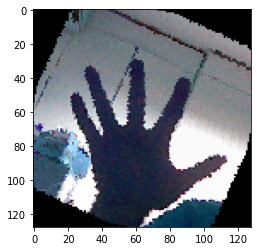

In [19]:
plt.imshow(test[0][0][2].permute(1,2,0).numpy())

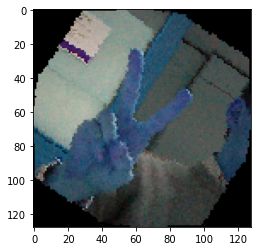

In [20]:
plt.imshow(test[0][0][31].permute(1,2,0))

In [21]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 3),nn.Softmax())
        
    def forward(self, x):
        
#         print(0,x)
        x = self.features1(x)
#         print(x)
        x = self.features2(x)
        x = F.relu(x)
#         print(111)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
#         print(123)
        return self.classifier(x)

In [22]:
model = BB_model()
max_lr=0.004
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=max_lr)
epochs = 10
# if torch.cuda.is_available(): 
#     torch.cuda.empty_cache()

In [23]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

In [46]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
#     max_lr=0.003

    
    for x, y_class in train_dl:
        
#         print(y_class)
 
        batch = y_class.shape[0]
#         x = x.cuda().float()
#         y_class = y_class.cuda()
        
        out_class= model(x)
        loss = F.cross_entropy(out_class, y_class, reduction="sum")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         scheduler.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
#     if i==30 :
#         -+max_lr=0.002
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class in valid_dl:
        batch = y_class.shape[0]
#         x = x.cuda().float()
#         y_class = y_class.cuda()
        out_class= model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f " % (train_loss, val_loss, val_acc ))

train_loss 0.639 val_loss 1.081 val_acc 0.793 
train_loss 0.619 val_loss 1.125 val_acc 0.793 
train_loss 0.589 val_loss 1.035 val_acc 0.793 
train_loss 0.603 val_loss 1.036 val_acc 0.828 
train_loss 0.585 val_loss 1.026 val_acc 0.845 
train_loss 0.596 val_loss 1.059 val_acc 0.897 
train_loss 0.580 val_loss 1.042 val_acc 0.897 
train_loss 0.589 val_loss 1.034 val_acc 0.897 
train_loss 0.585 val_loss 1.022 val_acc 0.897 
train_loss 0.595 val_loss 1.050 val_acc 0.897 


In [51]:
# torch.save(model1.state_dict(), 'models/test3343')

In [28]:
# model.load_state_dict(torch.load('models/test3340'))

In [54]:
# torch.save(model, 'models/test3353')

In [29]:
# model1 = BB_model()
# model1.load_state_dict(torch.load('models/test3343'))
# model1.eval()

In [30]:
# model1 = torch.load('models/test3353')
# model1.eval()

In [595]:
cap=cv2.VideoCapture(0)

In [693]:
ret, image = cap.read()
# image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [694]:
print(0,image.shape)

0 (480, 640, 3)


In [695]:
cv2.imshow('123',image )
cv2.waitKey(0)
cv2.destroyAllWindows ()

In [696]:
cv2.imread('test/3_rgb.png').shape

(480, 640, 3)

In [697]:
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('test/8_rgb.png', image)

image_width,image_height, x_min,y_min,x_max,y_max=get_box('test/8_rgb.png')

x_min,y_min,x_max,y_max
image1=cv2.imread('test/8_rgb.png')


im = cv2.resize(image1[y_min:y_max, x_min:x_max],(128,128))

im=np.asarray(im)/255

im=np.rollaxis(im, 2)
im = im[np.newaxis,:]
im=torch.as_tensor(im).float()


In [698]:
x_min,y_min,x_max,y_max

(89, 153, 321, 406)

In [699]:
im.shape

torch.Size([1, 3, 128, 128])

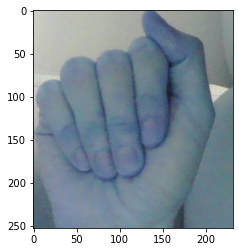

In [700]:
plt.imshow(image1[y_min:y_max, x_min:x_max])

In [701]:
out_class=model(im)

In [702]:
out_class

tensor([[9.9651e-01, 3.1107e-03, 3.7948e-04]], grad_fn=<SoftmaxBackward>)

In [703]:
 _, pred = torch.max(out_class, 1)

In [704]:
pred

tensor([0])

In [705]:
cap.release()
cv2.destroyAllWindows()

In [25]:
class Define_gestures():
    
#  инициализируем модель 

    def __init__(self,model):
            
            self.model = model
            
            self.make_gestures()
            
#  ищем лицо
            
    def make_gestures(self):
        
        mtcnn = MTCNN()
        
    
        while cap.isOpened():
            
            try:

                success, image = cap.read()

                if not success:
                    continue

                boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)


                if probs :

                    self.get_gestures()         

                    
            except Exception as e:
                print('Something wrong!')
                print(f'error : {e}')
                
        return cap.release()
            
#      ищем кисть и совершаем действие 

    def get_gestures(self):
        
        while cap.isOpened():

                success, image = cap.read()


                if not success:

                    continue
        
                predict=self.def_gesture(image)


                if predict==0:

                    cv2.putText(image,'00000000', (int(200), int(300)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                elif predict==1:

                    cv2.putText(image,'111111111', (int(200), int(300)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                elif predict==2:

                    cv2.putText(image,'222222222', (int(200), int(300)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    

                cv2.imshow("gestures", image)
                if cv2.waitKey(1) & 0xFF == 27:
                    cv2.destroyAllWindows()
                    return cap.release()

# локализуем кисть и классифицируем ее                
                
    def def_gesture(self,image):
        
        with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.65,
        min_tracking_confidence=0.65,
        ) as hands:

            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if results.multi_handedness:


                image_height, image_width, _ = image.shape

                x_max=0
                y_max=0
                x_min=image_width
                y_min=image_height

                for i in range(len(results.multi_hand_landmarks[0].landmark)):

                    x_max=max(results.multi_hand_landmarks[0].landmark[i].x,x_max)
                    y_max=max(results.multi_hand_landmarks[0].landmark[i].y,y_max)
                    x_min=min(results.multi_hand_landmarks[0].landmark[i].x,x_min)
                    y_min=min(results.multi_hand_landmarks[0].landmark[i].y,y_min)


                x_max=int(x_max*image_width*1.2)
                y_max=int(y_max*image_height*1.2)
                x_min=int(x_min*image_width*0.8)
                y_min=int(y_min*image_height*0.8) 
                x_max=max(x_max,0)
                y_max=max(y_max,0)
                x_min=max(x_min,0)
                y_min=max(y_min,0)
                x_max=min(x_max,image_width)
                y_max=min(y_max,image_height)
                x_min=min(x_min,image_width)
                y_min=min(y_min,image_height)
                

                im = cv2.resize(image[y_min:y_max, x_min:x_max],(128,128))
#                 plt.imshow(im)
#                 plt.show()
                im=np.asarray(im)/255
                im=np.rollaxis(im, 2)
                im = im[np.newaxis,:]
                im=torch.as_tensor(im).float()

                out_class=self.model(im)
                _, pred = torch.max(out_class, 1)
                predict=pred

                return pred






In [31]:
cap=cv2.VideoCapture(0)
Define_gestures(model1)

In [711]:
cap.release()
cv2.destroyAllWindows()